In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

df = pd.read_csv("./cic_ids_smote03_pca25.csv")
#df = pd.read_csv("/Users/anchanghun/Downloads/CIC-Dataset/cleaned_improved_cicids2017.csv")

In [3]:
X_train =pd.read_csv("D:/dataset/0219_Paper_Dataset/train_pca.csv")
X_test =pd.read_csv("D:/dataset/0219_Paper_Dataset/test_pca.csv")

In [4]:
X_train.shape, X_test.shape

((6378151, 26), (405464, 26))

In [5]:
y_train = X_train['label']
X_train = X_train.drop(labels='label',axis=1)

In [6]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)

In [7]:
X_train.shape, X_test.shape

((6378151, 25), (405464, 25))

In [8]:
y_train.shape, y_test.shape

((6378151,), (405464,))

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [12]:
from tensorflow.keras.optimizers.experimental import AdamW


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

# 모델 하이퍼파라미터
num_classes = 9  # 정상(1) + 8개 공격
latent_dim = 32  # 잠재 공간 크기 증가
embedding_dim = 64  # Transformer 차원 증가
num_heads = 4  # Multi-head attention
ff_dim = 128  # Feed-forward layer 크기 증가

# 샘플링 함수 (Reparameterization Trick)
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * K.clip(z_log_sigma, -10, 10)) * epsilon

# Transformer 인코더 블록
def transformer_encoder(inputs, num_heads, ff_dim):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = layers.Dropout(0.1)(x)
    res = x + inputs  # Residual Connection

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dense(embedding_dim)(x)
    return x + res  # Residual Connection

# CVAE-Transformer 모델 정의
def cvae_transformer(X, y):
    features = X.shape[1]  # 특징 수
    input_x = Input(shape=(features,), name='InputFeatures')
    input_y = Input(shape=(num_classes,), name='InputLabels')

    # **CNN + Transformer 기반 인코더**
    x = layers.Dense(128, activation="relu")(input_x)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((-1, 1))(x)  # 🔹 Reshape 수정 (자동 계산)
    x = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Transformer 적용
    x = layers.Reshape((1, embedding_dim))(x)
    x = transformer_encoder(x, num_heads, ff_dim)
    x = layers.GlobalAveragePooling1D()(x)

    # **잠재 공간 학습 (Reparameterization Trick)**
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(x)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

    # **개선된 Decoder (Dense 추가)**
    z_combined = layers.Concatenate()([z, input_y])  # 잠재 벡터 + 라벨 정보 활용
    decoder_x = layers.Dense(256, activation="relu")(z_combined)
    decoder_x = layers.BatchNormalization()(decoder_x)
    decoder_x = layers.Dense(128, activation="relu")(decoder_x)
    decoder_x = layers.Dense(64, activation="relu")(decoder_x)
    decoder_x = layers.Dense(features, activation='sigmoid', name='ReconstructedOutput')(decoder_x)

    # CVAE 모델 생성
    model = Model([input_x, input_y], decoder_x)

    # **손실 함수 정의 (KL Divergence + Reconstruction Loss)**
    def cvae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
        reconstruction_loss = K.mean(K.square(x - x_decoded_mean) + 1e-10)  # MSE 기반 복원 손실
        kl_loss = -0.5 * K.sum(1 + K.clip(z_log_sigma, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_sigma, -10, 10)), axis=-1)
        kl_loss_weighted = kl_loss * 0.1  # KL 손실 가중치 증가 (기존 0.01 → 0.1)
        return K.mean(reconstruction_loss + kl_loss_weighted)

    model.add_loss(cvae_loss(input_x, decoder_x, z_mean, z_log_sigma))

    return model

# CVAE Transformer 학습 (정상 + 여러 공격 데이터 포함)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)  # 라벨 원핫 인코딩
model = cvae_transformer(X_train, y_train_onehot)
model.compile(optimizer=AdamW(learning_rate=0.001), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([X_train, y_train_onehot], X_train,  # Reconstruction
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=128,  # 🔹 Batch size 증가 (64 → 128)
                    callbacks=[early_stopping])

# 🔹 인코더의 잠재 변수 추출
encoder = Model(model.input, model.get_layer('z').output)
Z_test = encoder.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])

# 🔹 K-Means 클러스터링
num_attack_classes = num_classes - 1  # 정상 제외한 공격 클래스 수
kmeans = KMeans(n_clusters=num_attack_classes, random_state=42)
cluster_labels = kmeans.fit_predict(Z_test)

# 🔹 클러스터 라벨을 실제 라벨과 매칭
def map_clusters_to_labels(y_true, y_pred):
    mapping = {}
    for cluster in np.unique(y_pred):
        true_labels = y_true[y_pred == cluster]
        most_common = mode(true_labels)[0][0]  # 가장 많이 등장한 실제 라벨을 해당 클러스터에 매칭
        mapping[cluster] = most_common
    return np.array([mapping[cluster] for cluster in y_pred])

mapped_labels = map_clusters_to_labels(y_test, cluster_labels)

# 🔹 성능 평가
print("K-Means 비지도 학습 성능 평가:")
print(accuracy_score(y_test, mapped_labels))
print(classification_report(y_test, mapped_labels))


Epoch 1/50
44847/44847 [==============================] - 587s 13ms/step - loss: 9.0123 - accuracy: 0.6490 - val_loss: 0.3157 - val_accuracy: 3.1357e-05
Epoch 2/50
44847/44847 [==============================] - 576s 13ms/step - loss: 8.9882 - accuracy: 0.5630 - val_loss: 0.2486 - val_accuracy: 0.0042
Epoch 3/50
44847/44847 [==============================] - 561s 12ms/step - loss: 8.9854 - accuracy: 0.5384 - val_loss: 0.2316 - val_accuracy: 0.0026
Epoch 4/50
44847/44847 [==============================] - 552s 12ms/step - loss: 8.9839 - accuracy: 0.5809 - val_loss: 0.2196 - val_accuracy: 0.0032
Epoch 5/50
44847/44847 [==============================] - 548s 12ms/step - loss: 8.9825 - accuracy: 0.6005 - val_loss: 0.2222 - val_accuracy: 0.0032
Epoch 6/50
44847/44847 [==============================] - 548s 12ms/step - loss: 8.9780 - accuracy: 0.5602 - val_loss: 0.2178 - val_accuracy: 0.0031
Epoch 7/50
44847/44847 [==============================] - 546s 12ms/step - loss: 8.9770 - accuracy: 0.

C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means 비지도 학습 성능 평가:
0.7865285204111833
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    318909
           1       0.00      0.00      0.00     19029
           2       0.00      0.00      0.00      1513
           3       0.00      0.00      0.00     31694
           4       0.00      0.00      0.00       348
           5       0.00      0.00      0.00       772
           6       0.00      0.00      0.00       794
           7       0.00      0.00      0.00     31813
           8       0.00      0.00      0.00       592

    accuracy                           0.79    405464
   macro avg       0.09      0.11      0.10    405464
weighted avg       0.62      0.79      0.69    405464



C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


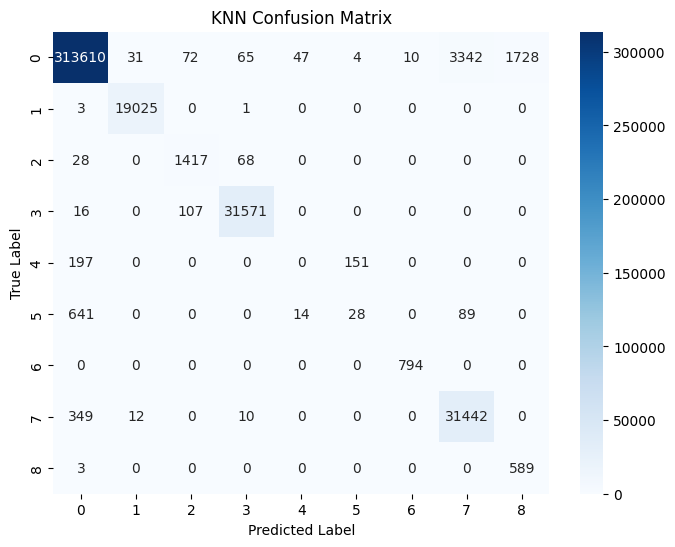

KNN Classifier Accuracy: 0.9827654243040073

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    318909
           1       1.00      1.00      1.00     19029
           2       0.89      0.94      0.91      1513
           3       1.00      1.00      1.00     31694
           4       0.00      0.00      0.00       348
           5       0.15      0.04      0.06       772
           6       0.99      1.00      0.99       794
           7       0.90      0.99      0.94     31813
           8       0.25      0.99      0.40       592

    accuracy                           0.98    405464
   macro avg       0.69      0.77      0.70    405464
weighted avg       0.98      0.98      0.98    405464



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

# ✅ KNN 모델 생성 및 학습 (k=5 사용, 필요하면 조절 가능)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)  # X_train: 학습 데이터, y_train: 실제 라벨

# ✅ 예측 수행
y_pred = knn.predict(X_test)

# ✅ 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()

# ✅ 성능 평가 지표 출력
print("KNN Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


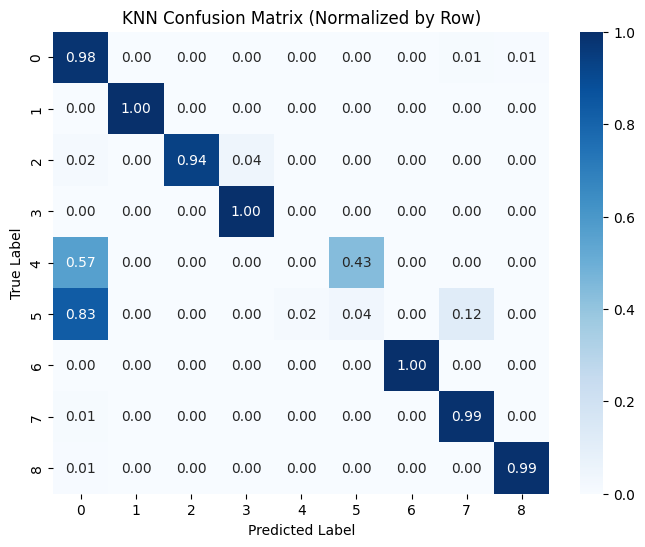

KNN Classifier Accuracy: 0.9827654243040073

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    318909
           1       1.00      1.00      1.00     19029
           2       0.89      0.94      0.91      1513
           3       1.00      1.00      1.00     31694
           4       0.00      0.00      0.00       348
           5       0.15      0.04      0.06       772
           6       0.99      1.00      0.99       794
           7       0.90      0.99      0.94     31813
           8       0.25      0.99      0.40       592

    accuracy                           0.98    405464
   macro avg       0.69      0.77      0.70    405464
weighted avg       0.98      0.98      0.98    405464



In [19]:

# ✅ 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ 정답 및 오분류 비율 계산 (행 단위 정규화)
conf_matrix_ratio = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  # 각 행을 해당 클래스 총 개수로 나눔

# ✅ 혼동 행렬 시각화 (정답률 + 오분류율 포함)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ratio, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix (Normalized by Row)")
plt.show()

# ✅ 성능 평가 지표 출력
print("KNN Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


12671/12671 [==============================] - 28s 2ms/step
K-Means 다중 분류 성능 평가:
Accuracy: 0.7865


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    318909
           1       0.00      0.00      0.00     19029
           2       0.00      0.00      0.00      1513
           3       0.00      0.00      0.00     31694
           4       0.00      0.00      0.00       348
           5       0.00      0.00      0.00       772
           6       0.00      0.00      0.00       794
           7       0.00      0.00      0.00     31813
           8       0.00      0.00      0.00       592

    accuracy                           0.79    405464
   macro avg       0.09      0.11      0.10    405464
weighted avg       0.62      0.79      0.69    405464



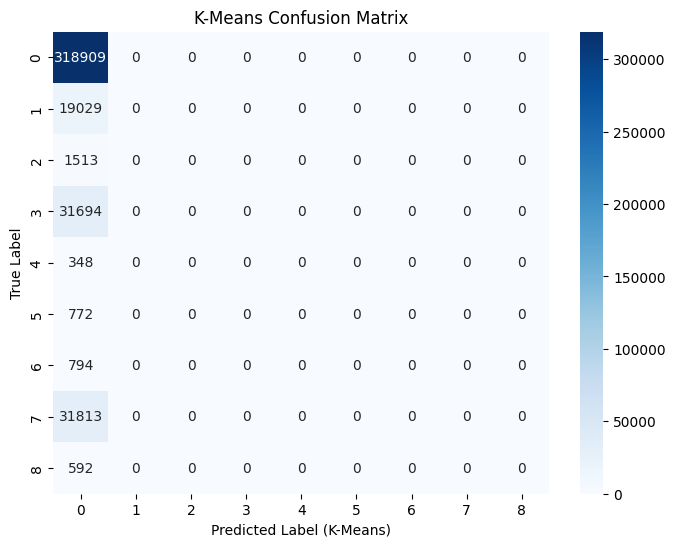

In [20]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 인코더에서 Latent Space 추출
Z_train = encoder.predict([X_train, tf.keras.utils.to_categorical(y_train, num_classes)])
Z_test = encoder.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])

# ✅ K-Means 클러스터링 (num_classes 개의 클러스터 생성)
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(Z_train)  # 학습 데이터로 클러스터링

# ✅ 클러스터와 실제 라벨 매핑 (가장 많이 등장하는 라벨 기준)
def map_clusters_to_labels(y_true, y_pred):
    mapping = {}
    for cluster in np.unique(y_pred):
        true_labels = y_true[y_pred == cluster]
        most_common = mode(true_labels)[0][0]  # 가장 많은 실제 라벨을 해당 클러스터에 매핑
        mapping[cluster] = most_common
    return np.array([mapping[cluster] for cluster in y_pred])

# ✅ 학습 데이터에서 클러스터 매핑 생성
mapped_train_labels = map_clusters_to_labels(y_train, cluster_labels)

# ✅ 테스트 데이터에 클러스터링 적용 후 매핑 변환
test_cluster_labels = kmeans.predict(Z_test)
mapped_test_labels = np.array([mapped_train_labels[label] for label in test_cluster_labels])

# ✅ 성능 평가
print("K-Means 다중 분류 성능 평가:")
print(f"Accuracy: {accuracy_score(y_test, mapped_test_labels):.4f}")
print("\nClassification Report:\n", classification_report(y_test, mapped_test_labels))

# ✅ 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, mapped_test_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label (K-Means)")
plt.ylabel("True Label")
plt.title("K-Means Confusion Matrix")
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 정상 데이터만 사용하여 CVAE-Transformer 학습
normal_indices = np.where(y_train == 0)[0]  # 정상 데이터의 인덱스
X_train_normal = X_train.iloc[normal_indices]  # 🔹 .iloc[] 사용하여 정수형 인덱스로 접근

# 원핫 인코딩된 라벨 생성 (정상 데이터만)
y_train_normal = tf.keras.utils.to_categorical(y_train.iloc[normal_indices], num_classes)

# CVAE-Transformer 모델 정의 및 학습
model = cvae_transformer(X_train_normal, y_train_normal)
model.compile(optimizer=AdamW(learning_rate=0.001))
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=128,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# ✅ 테스트 데이터에서 재구성 오류 계산
X_test_reconstructed = model.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)  # MSE 계산



Epoch 1/50
8970/8970 [==============================] - 114s 12ms/step - loss: 6.1050 - val_loss: 5.4030
Epoch 2/50
8970/8970 [==============================] - 111s 12ms/step - loss: 6.0767 - val_loss: 5.3976
Epoch 3/50
8970/8970 [==============================] - 112s 12ms/step - loss: 6.0709 - val_loss: 5.3812
Epoch 4/50
8970/8970 [==============================] - 111s 12ms/step - loss: 6.0653 - val_loss: 5.3855
Epoch 5/50
8970/8970 [==============================] - 109s 12ms/step - loss: 6.0631 - val_loss: 5.3898
Epoch 6/50
8970/8970 [==============================] - 111s 12ms/step - loss: 6.0574 - val_loss: 5.3819
Epoch 7/50
8970/8970 [==============================] - 110s 12ms/step - loss: 6.0548 - val_loss: 5.3736
Epoch 8/50
8970/8970 [==============================] - 111s 12ms/step - loss: 6.0536 - val_loss: 5.3706
Epoch 9/50
8970/8970 [==============================] - 112s 13ms/step - loss: 6.0542 - val_loss: 5.3745
Epoch 10/50
8970/8970 [==============================] 

AttributeError: 'Series' object has no attribute 'reshape'

12671/12671 [==============================] - 27s 2ms/step
K-Means (CVAE 잠재 공간 기반) 다중 분류 성능 평가:
Accuracy: 0.7865


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    318909
           1       0.00      0.00      0.00     19029
           2       0.00      0.00      0.00      1513
           3       0.00      0.00      0.00     31694
           4       0.00      0.00      0.00       348
           5       0.00      0.00      0.00       772
           6       0.00      0.00      0.00       794
           7       0.00      0.00      0.00     31813
           8       0.00      0.00      0.00       592

    accuracy                           0.79    405464
   macro avg       0.09      0.11      0.10    405464
weighted avg       0.62      0.79      0.69    405464



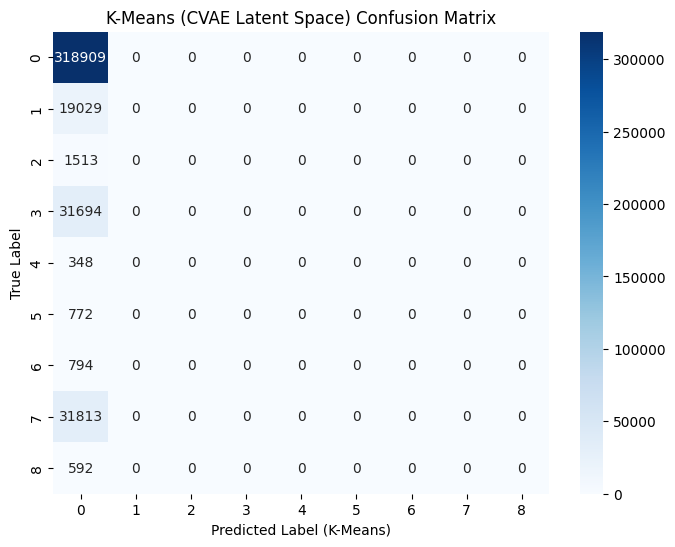

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ CVAE의 인코더를 사용하여 잠재 공간 벡터 추출
encoder = Model(model.input, model.get_layer('z').output)  # CVAE Transformer의 인코더 모델
Z_test = encoder.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])  # (N, latent_dim)

# ✅ K-Means 클러스터링 수행 (num_classes 개의 클러스터 생성)
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(Z_test)  # ✅ CVAE 잠재 공간 사용

# ✅ 클러스터와 실제 라벨 매핑 (각 클러스터에서 가장 많이 등장한 라벨을 대표 라벨로 설정)
def map_clusters_to_labels(y_true, y_pred):
    mapping = {}
    y_true = np.array(y_true)  # Pandas Series라면 NumPy 배열로 변환

    for cluster in np.unique(y_pred):
        true_labels = y_true[y_pred == cluster]  # 클러스터 내 실제 라벨 모음
        if len(true_labels) > 0:  # 빈 클러스터 방지
            most_common = mode(true_labels)[0][0]  # ✅ 최신 버전에서 'keepdims' 없이 사용
            mapping[cluster] = most_common
        else:
            mapping[cluster] = -1  # 에러 방지용 더미값

    return np.array([mapping[cluster] for cluster in y_pred])

mapped_labels = map_clusters_to_labels(y_test, cluster_labels)

# ✅ 성능 평가 출력
print("K-Means (CVAE 잠재 공간 기반) 다중 분류 성능 평가:")
print(f"Accuracy: {accuracy_score(y_test, mapped_labels):.4f}")
print("\nClassification Report:\n", classification_report(y_test, mapped_labels))

# ✅ 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, mapped_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label (K-Means)")
plt.ylabel("True Label")
plt.title("K-Means (CVAE Latent Space) Confusion Matrix")
plt.show()


12671/12671 [==============================] - 28s 2ms/step
GMM (CVAE 잠재 공간 기반) 다중 분류 성능 평가:
Accuracy: 0.7865


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    318909
           1       0.00      0.00      0.00     19029
           2       0.00      0.00      0.00      1513
           3       0.00      0.00      0.00     31694
           4       0.00      0.00      0.00       348
           5       0.00      0.00      0.00       772
           6       0.00      0.00      0.00       794
           7       0.00      0.00      0.00     31813
           8       0.00      0.00      0.00       592

    accuracy                           0.79    405464
   macro avg       0.09      0.11      0.10    405464
weighted avg       0.62      0.79      0.69    405464



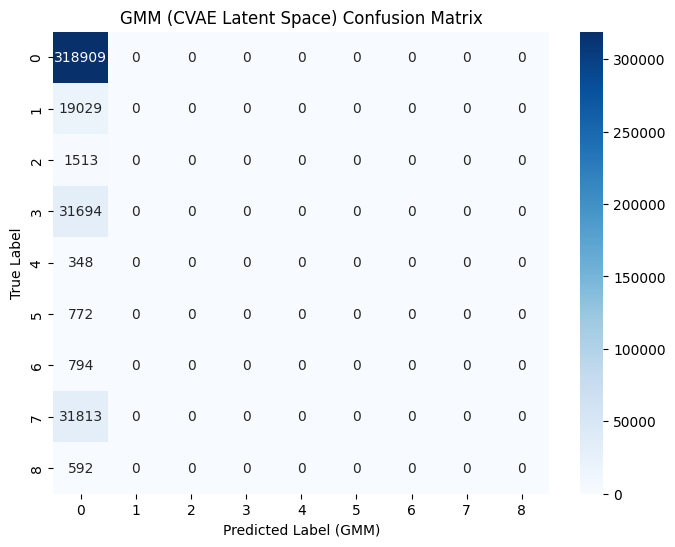

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model

# ✅ CVAE Transformer 인코더에서 잠재 벡터 추출
encoder = Model(model.input, model.get_layer('z').output)  # CVAE Transformer 인코더 모델
Z_test = encoder.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])  # (N, latent_dim)

# ✅ GMM 클러스터링 수행 (num_classes 개의 클러스터 생성)
gmm = GaussianMixture(n_components=num_classes, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(Z_test)  # ✅ CVAE 잠재 공간 활용

# ✅ 클러스터와 실제 라벨 매핑 (각 클러스터에서 가장 많이 등장한 라벨을 대표 라벨로 설정)
def map_clusters_to_labels(y_true, y_pred):
    mapping = {}
    y_true = np.array(y_true)  # Pandas Series라면 NumPy 배열로 변환

    for cluster in np.unique(y_pred):
        true_labels = y_true[y_pred == cluster]  # 클러스터 내 실제 라벨 모음
        if len(true_labels) > 0:  # 빈 클러스터 방지
            most_common = mode(true_labels)[0][0]  # ✅ 가장 많이 등장한 라벨 선택
            mapping[cluster] = most_common
        else:
            mapping[cluster] = -1  # 에러 방지용 더미값

    return np.array([mapping[cluster] for cluster in y_pred])

mapped_labels = map_clusters_to_labels(y_test, cluster_labels)

# ✅ 성능 평가 출력
print("GMM (CVAE 잠재 공간 기반) 다중 분류 성능 평가:")
print(f"Accuracy: {accuracy_score(y_test, mapped_labels):.4f}")
print("\nClassification Report:\n", classification_report(y_test, mapped_labels))

# ✅ 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, mapped_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label (GMM)")
plt.ylabel("True Label")
plt.title("GMM (CVAE Latent Space) Confusion Matrix")
plt.show()

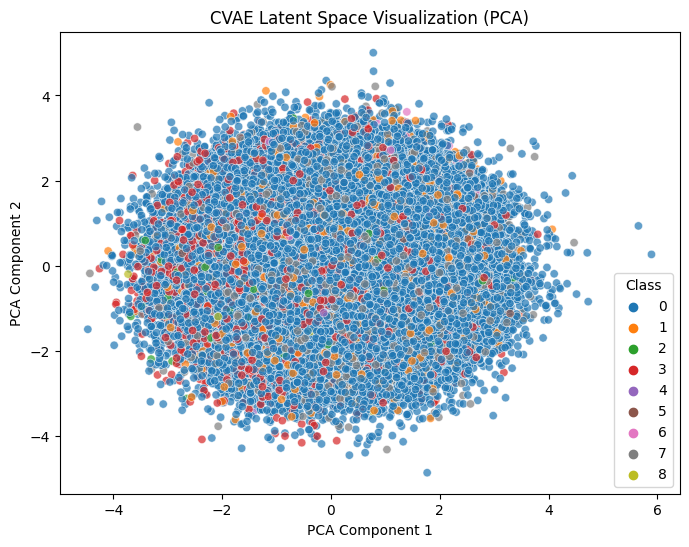

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# ✅ PCA를 사용하여 2D로 차원 축소
pca = PCA(n_components=2)
Z_test_2D_pca = pca.fit_transform(Z_test)

# ✅ PCA 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_test_2D_pca[:, 0], y=Z_test_2D_pca[:, 1], hue=y_test, palette="tab10", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("CVAE Latent Space Visualization (PCA)")
plt.legend(title="Class")
plt.show()

12671/12671 [==============================] - 28s 2ms/step


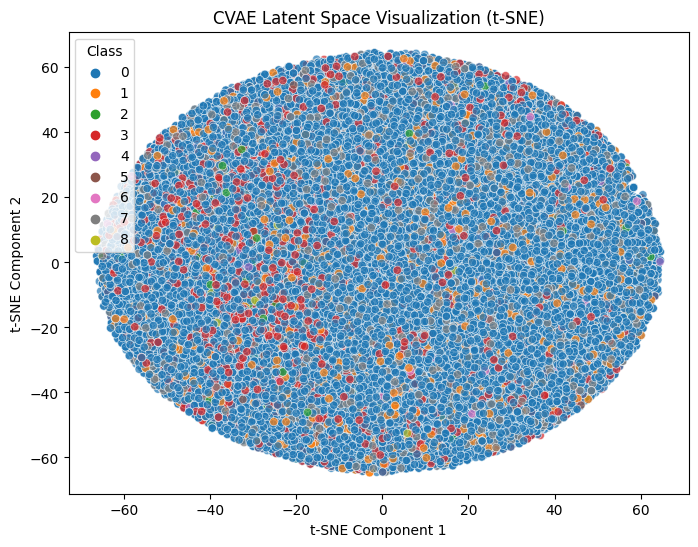

In [32]:
# ✅ CVAE Transformer 인코더에서 잠재 벡터 추출
encoder = Model(model.input, model.get_layer('z').output)  # CVAE Transformer 인코더 모델
Z_test = encoder.predict([X_test, tf.keras.utils.to_categorical(y_test, num_classes)])  # (N, latent_dim)

# ✅ t-SNE를 사용하여 2D로 차원 축소
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # perplexity는 보통 5~50 범위
Z_test_2D = tsne.fit_transform(Z_test)

# ✅ 시각화 (클래스별 색상 다르게 설정)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_test_2D[:, 0], y=Z_test_2D[:, 1], hue=y_test, palette="tab10", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("CVAE Latent Space Visualization (t-SNE)")
plt.legend(title="Class")
plt.show()